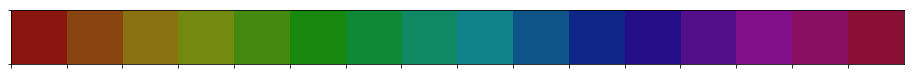

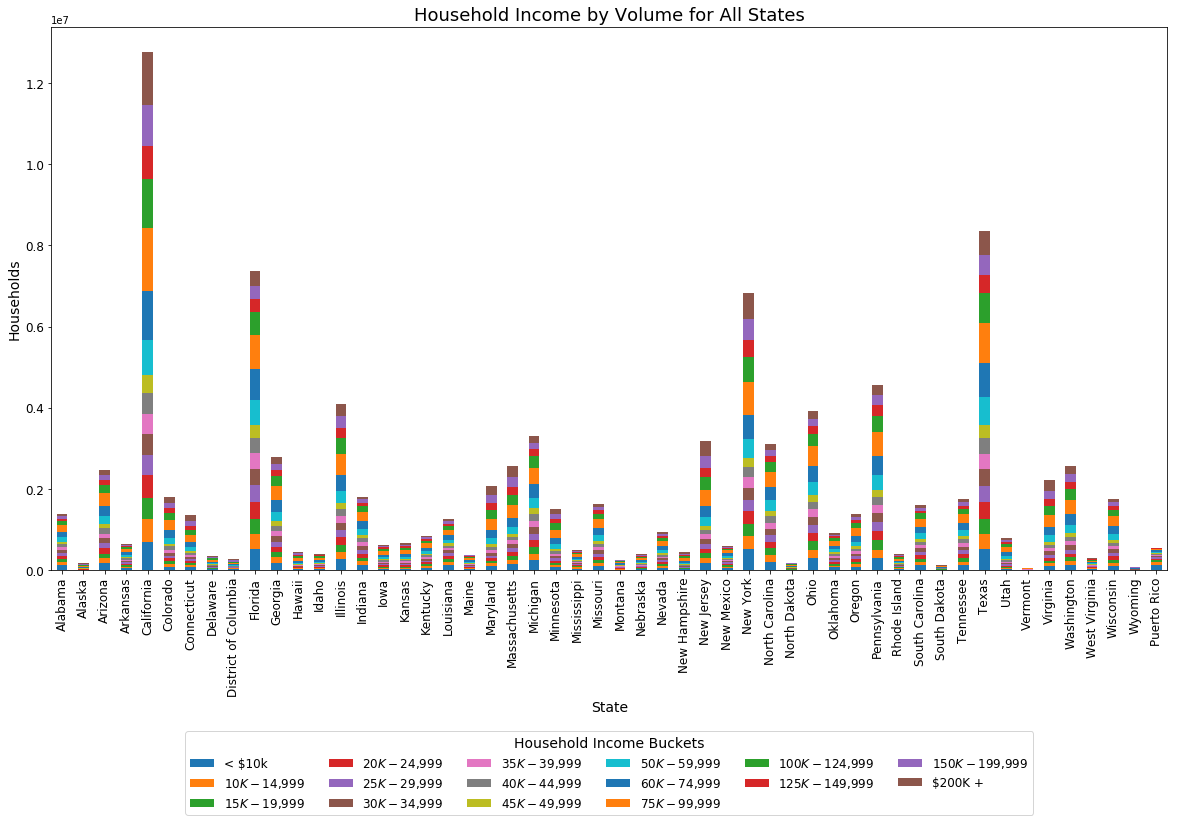

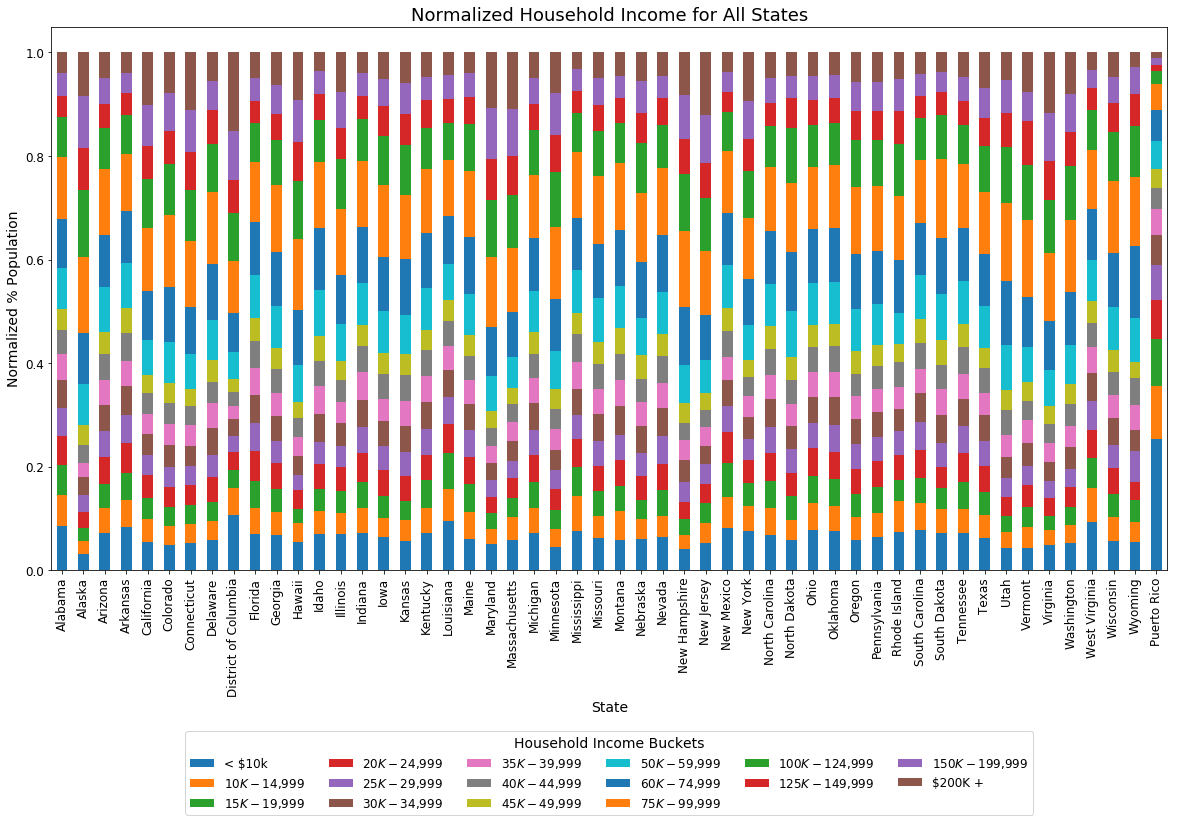

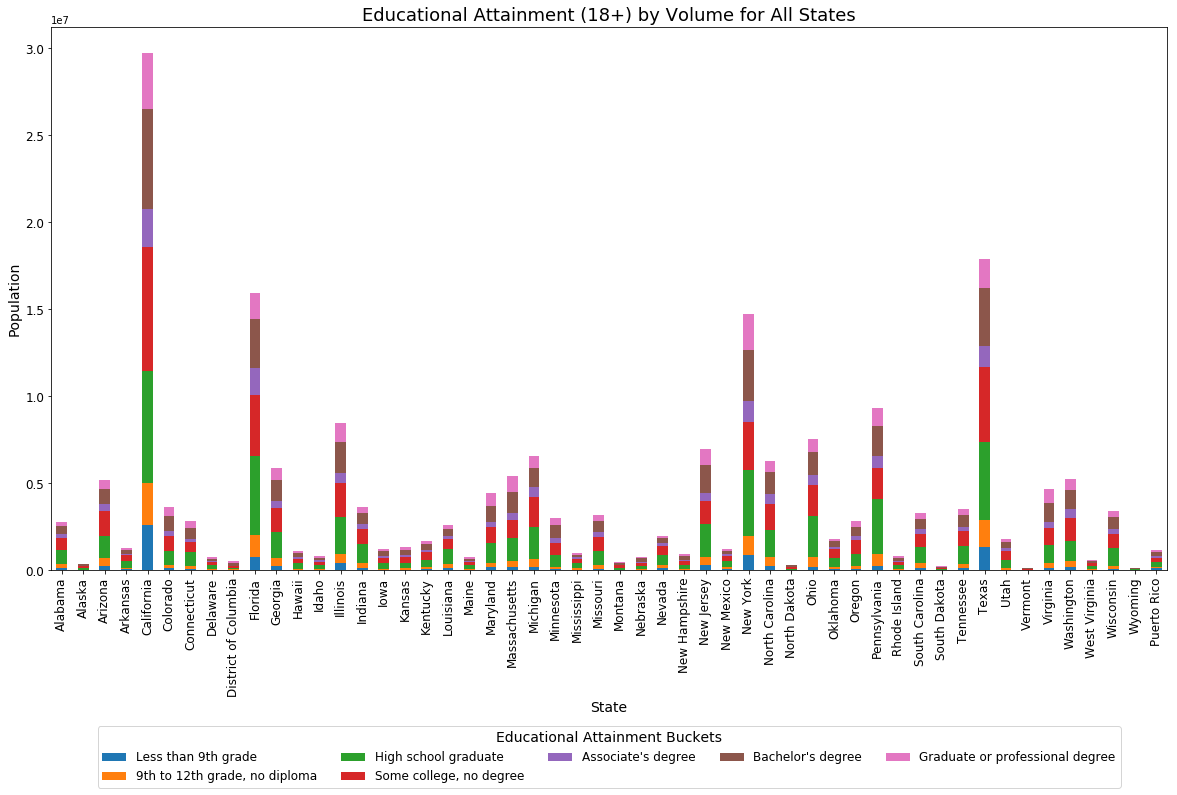

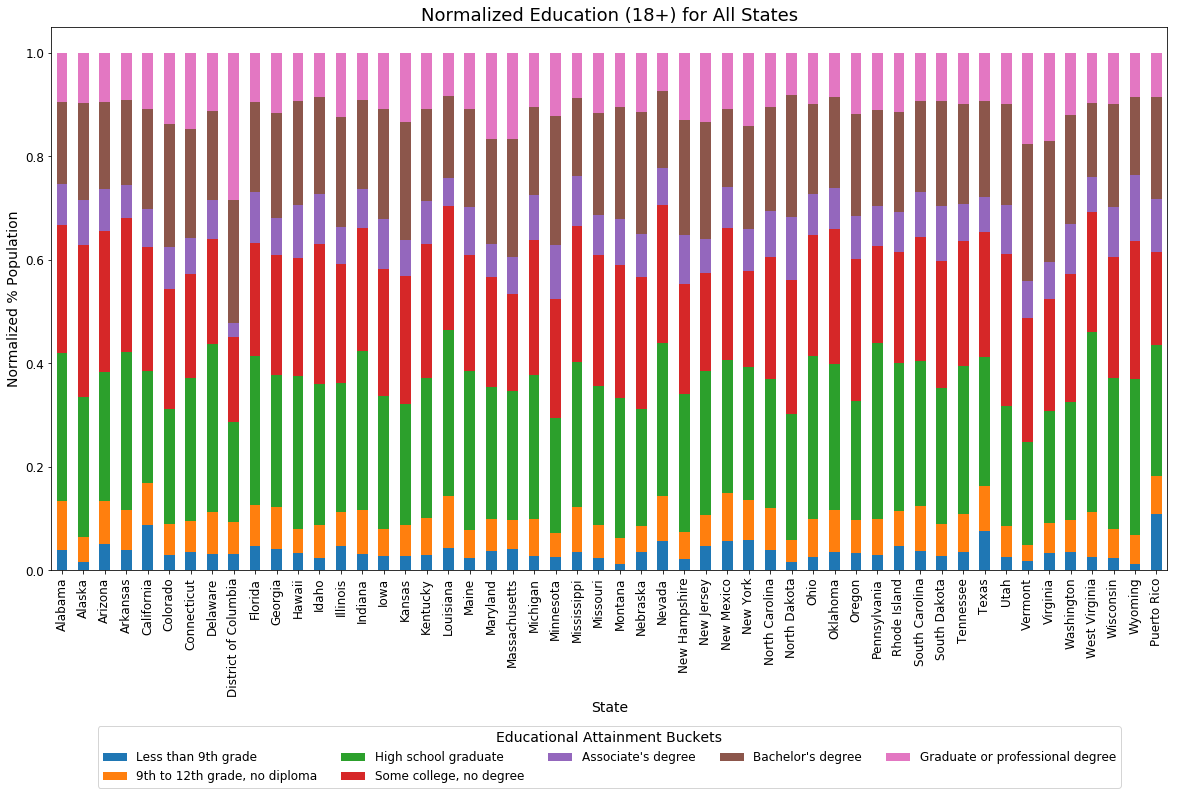

In [292]:
# Dependencies
import requests as req
import numpy as np
import json
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

###############################################################################
# Income and Education DataFrames to use:
    # By County:
        # By Value:
            # incomeDFmapped - INCOME
            # eduDFmapped - EDUCATION
        # Normalized
            # normIncome - INCOME
            # normEdu - EDUCATION
    # By State:
        # By Value:
            # incomeByState - INCOME
            # eduByState - EDUCATION
        # Normalized
            # incomeByStateNorm - INCOME
            # eduByStateNorm - EDUCATION
###############################################################################

##### MAP GEOCODES (FIPS) TO STATES/COUNTIES #####
# Create function to make Geocode Data into DataFrame
def makeGeocodeDF(pdExel,sumLevel,fipsCol1,colName,fipsCol2=0):
    # Create DF out of excel
    df = pdExel.loc[pdExel['Summary Level'] == sumLevel]

    # If the summary level is 'county'
    if sumLevel == 50:
        # Add both fips code levels
        df = df[[fipsCol1,fipsCol2,'Area Name (including legal/statistical area description)']]
    else:
        # only add one fips code level
        df = df[[fipsCol1,'Area Name (including legal/statistical area description)']]

    # Rename columns
    df = df.rename(columns={'Area Name (including legal/statistical area description)' : colName})

    # Return DataFrame
    return df

# Read excel file of geo codes
geocodeMap = pd.read_excel('resources/2015-allgeocodes.xlsx', sheetname='Sheet1')

# Create DataFrame of States/State FIPS
geocodeMapState = makeGeocodeDF(geocodeMap,40,'State Code (FIPS)','State')
# Create DataFrame of County Names/County FIPS/State FIPS/
geocodeMapCounty = makeGeocodeDF(geocodeMap,50,'County Code (FIPS)','County','State Code (FIPS)')
# Create DataFrame of States and Abbreviations
abbrMap = pd.read_excel('resources/stateAbbreviation.xlsx')

# Create merged DataFrame with County and State FIPS and Names
geocodeMap = pd.merge(geocodeMapState,geocodeMapCounty, how='outer', on='State Code (FIPS)')

#/ Variables/DFs to use:
    #/ For state/county mapping: geocodeMap
    #/ remember to merge on BOTH State and County (county FIPs repeat)

##### CENSUS DATA #####
#/// SETUP 'GET' Variables \\\#
# Function to dynamically create variable ID lists
def createIdList(r1,r2,s,avoid=[]): #range start, range stop, id string, avoid ids (optional)

    i = [] # List variable

    # For all variables in the range
    for x in range(r1,r2):

        # If there are variables to avoid, pass
        if x in avoid:
            pass

        # If id is greater than 9
        elif x > 9:
            i.append(s+str(x)+'E')

        # Add a leading zero for IDs below 10
        else:
            i.append(s+'0'+str(x)+'E')

    # Return list
    return i

# Function to create a dictionary of IDs and their string
def createIdDict(k,v):

    n = 0 #counter
    d = {} #dictionary

    # For each ID in list
    for x in k:

        # Add it as a key and add appropriate bucket as value
        d[x] = v[n%len(v)] #use remainder to determine bucket (if it loops)
        n += 1 # Increase counter

    # Rename state/county to match geomap
    d['state'] = 'State Code (FIPS)'
    d['county'] = 'County Code (FIPS)'

    # Return Dictionary
    return d

# HOUSEHOLD INCOME: Create List and Dictionary
householdIncomeIdList = createIdList(2,18,'B19001_0')
householdIncomeBuckets = ['< $10k',
                          '$10K - $14,999',
                          '$15K - $19,999',
                          '$20K - $24,999',
                          '$25K - $29,999',
                          '$30K - $34,999',
                          '$35K - $39,999',
                          '$40K - $44,999',
                          '$45K - $49,999',
                          '$50K - $59,999',
                          '$60K - $74,999',
                          '$75K - $99,999',
                          '$100K - $124,999',
                          '$125K - $149,999',
                          '$150K - $199,999',
                          '$200K +']
householdIncomeDict = createIdDict(householdIncomeIdList,householdIncomeBuckets)

# EDUCATIONAL ATTAINMENT: Create List and Dictionary
notInclude = [1,2,3,11,19,27,35,43,44,52,60,68,76] #id's not to include in list
educationIdList = createIdList(1,84,'B15001_0',notInclude)
educationAttainmentBuckets = ['Less than 9th grade',
                              '9th to 12th grade, no diploma',
                              'High school graduate',
                              'Some college, no degree',
                              'Associate\'s degree',
                              'Bachelor\'s degree',
                              'Graduate or professional degree']
educationDict = createIdDict(educationIdList,educationAttainmentBuckets)
# Split education list in 2 because of 50 variable arg max
educationIdList1 = educationIdList[:int(len(educationIdList)/2)]
educationIdList2 = educationIdList[int(len(educationIdList)/2):]

# POPULATION: Create Dictionary
populationDict = createIdDict(['B01001_001E'],['Population'])

# Create string of ID's to query
idLists = [householdIncomeIdList,educationIdList1,educationIdList2] # List of lists
getArgs = []

# Create list of get arguments (all id's)
for l in idLists:

    getIds = '' #string

    # For all IDs in the list
    for i in l:

        getIds = getIds + i + ',' #add ID to final string

    getIds = getIds[:-1] #remove last comma
    getArgs.append(getIds) #add to ID list

# Append population to get args
getArgs.append((list(populationDict.keys()))[0])

#/// Setup Query URL \\\#
# Variables
year = 2016
apiKey = 'a9bba28cbc522f8f9d8ae3b88ef030fba6034516'
baseURL = 'https://api.census.gov/data/{}/acs/acs1/'.format(year)
forArgs = 'county:*'

# Create list of URLs to query
urlList = [] #empty list
for x in getArgs:
    URLArgs = '?get={}&for={}&key={}'.format(x,forArgs,apiKey)
    queryURL = baseURL + URLArgs
    urlList.append(queryURL)


#/// Create Dataframes \\\#
# Create function
def makeDataFrame(url,labelDict):

    #Get response data from API
    response = req.get(url)
    jsonData = response.json() #create json

    # Create data frame from json
    df = pd.DataFrame(jsonData, columns=jsonData[0]) #rename headers with first row values
    df = df.rename(columns=labelDict) #rename columnns using associated dictionary
    df = df.drop(df.index[0]) #remove first row

    # Remove leading zeros from state and county
    df['State Code (FIPS)'] = df['State Code (FIPS)'].str.lstrip('0')
    df['County Code (FIPS)'] = df['County Code (FIPS)'].str.lstrip('0')

    # Make all numbers in DF numeric
    df = df.apply(pd.to_numeric)

    return df

# Make DF using Function
incomeDF = makeDataFrame(urlList[0],householdIncomeDict)
eduDF1 = makeDataFrame(urlList[1],educationDict)
eduDF2 = makeDataFrame(urlList[2],educationDict)
populationDF = makeDataFrame(urlList[3],populationDict)

#/// Merge Education DataFrames \\\#
# Create joint DF
eduDF = pd.merge(eduDF1,eduDF2,how='outer',on=['State Code (FIPS)','County Code (FIPS)'])

# Create dictionary to remove appeneded X's and Y's on column names
removeAppend = {}
for i in educationAttainmentBuckets:
    s1 = i + '_x'
    s2 = i + '_y'
    removeAppend[s1] = i
    removeAppend[s2] = i

# Rename column headers
eduDF = eduDF.rename(columns=removeAppend)

# Sum columns with same names in DF
eduDF = eduDF.groupby(lambda x:x, axis=1).sum()

#/// Map Geocodes and add to DF \\\#
# Create function to automate
def mergeOnGeocode(df1,df2):
    try:
        return pd.merge(df1,df2,how='inner',on=['State Code (FIPS)','County Code (FIPS)'])
    except:
        return pd.merge(df1,df2,how='inner',on=['State Code (FIPS)'])


# Map census DFs to FIPS
incomeDFmapped = mergeOnGeocode(incomeDF,geocodeMap)
eduDFmapped = mergeOnGeocode(eduDF,geocodeMap)

popDFmapped = mergeOnGeocode(populationDF,geocodeMap)
popDFmapped = pd.merge(popDFmapped,abbrMap, how='inner',on=['State'])

#/ Variables/DFs to use:
    #/ To normalize data, use this DF: popDFmapped (FIPS mapped to names)
    #/ Income data DF to use: incomeDFmapped (FIPS mapped to names) or incomeDF (FIPS only)
    #/ Education data DF to use: eduDFmapped (FIPS mapped to names) or eduDF (FIPS only)

#/// Create Normalized DFs \\\*

# Create function to normalize data
def normalizeData(df1,df2,buckets):

    # Merge dicts on geocode
    df = mergeOnGeocode(df1,df2)

    # For each column, divide by the total population column
    for bucket in buckets:
        df[bucket] = df[bucket]/df['Population']

    # Drop population column
    df.drop(['Population'], axis=1, inplace=True)

    # Return df
    return df

# HOUSEHOLDS TOTAL: Create DF
var = 'B19001_001E'
householdDict = createIdDict([var],['Population']) #create dict

URLArgs = '?get={}&for={}&key={}'.format(var,forArgs,apiKey)
queryURL = baseURL + URLArgs #put together query URL

householdDF = makeDataFrame(queryURL,householdDict) #create DF

# +18 POPULATION TOTAL: Create DF
var = 'B15001_001E'
over18Dict = createIdDict([var],['Population']) #create dict

URLArgs = '?get={}&for={}&key={}'.format(var,forArgs,apiKey)
queryURL = baseURL + URLArgs #put together query URL

over18DF = makeDataFrame(queryURL,over18Dict) #create DF

# Normalize Income and Education DFs
normIncome = normalizeData(incomeDF,householdDF,householdIncomeBuckets) #normalizedIncome
normEdu = normalizeData(eduDF,over18DF,educationAttainmentBuckets) #normalizedEdu

#/// Create Normalized DFs for States \\\*

# Function to breakdown DFs by state FIPS
def breakdownByState(dfIn):
    df = dfIn.groupby(['State Code (FIPS)']).sum()
    df.drop(['County Code (FIPS)'], axis=1, inplace=True)
    df = df.reset_index()
    return df

# Function to set state as index
def setStateAsIndex(df):

    # Merge on state only
    df = mergeOnGeocode(df,geocodeMapState)
    df.drop('State Code (FIPS)', axis=1, inplace=True)
    df = df.set_index('State')
    return df

# Function to Normalize state DFs
def createStateNormDF (df1,df2,buckets):

    # Breakdown DFs by STate and Normalize
    df1n = breakdownByState(df1)
    df2n = breakdownByState(df2)
    df = normalizeData(df1n,df2n,buckets)

    # Set state as the index
    df = setStateAsIndex(df)

    return df

# Create State DF's
# Income
incomeByState = setStateAsIndex(breakdownByState(incomeDF))
incomeByState = incomeByState[householdIncomeBuckets] #reorder columns
# Education
eduByState = setStateAsIndex(breakdownByState(eduDF))
eduByState = eduByState[educationAttainmentBuckets] #reorder columns

# Create State Normalized DF's
# Income
incomeByStateNorm = createStateNormDF(incomeDF,householdDF,householdIncomeBuckets)
incomeByStateNorm = incomeByStateNorm[householdIncomeBuckets] #reorder columns
# Education
eduByStateNorm = createStateNormDF(eduDF,over18DF,educationAttainmentBuckets)
eduByStateNorm = eduByStateNorm[educationAttainmentBuckets] #reorder columns

#/// Create Bar Charts \\\*
sns.palplot(sns.hls_palette(16, l=.3, s=.8))

# Function to create bar charts
def createBarChart(df,title,x,y,lt,l,c):

    # Plot DF as bar graph
    df.plot(kind='bar',
            stacked=True,
            title=title,
            figsize=(20,10),
            fontsize=14
           )

    # Add title/labels
    plt.title(title,fontsize=18) #Create graph title
    plt.xlabel(x, fontsize=14) #Create x-axis label
    plt.ylabel(y,fontsize=14) #Create y-axis label
    plt.tick_params(axis='both', labelsize=12) #Format Axis

    # Add legend
    legend = plt.legend(loc='lower center',bbox_to_anchor=(.5, l), ncol=c, borderaxespad=0., title=lt, fontsize=12)
    legend.get_title().set_fontsize('14') #Set legend title font size

    # Show plot
    plt.show()

# Bar Chart: Household Income for All States
createBarChart(incomeByState,'Household Income by Volume for All States','State','Households','Household Income Buckets',-.45,6)

# Normalized Household Income for All States
createBarChart(incomeByStateNorm,'Normalized Household Income for All States','State','Normalized % Population','Household Income Buckets',-.45,6)

# Educational Attainment (18+) for All States
createBarChart(eduByState,'Educational Attainment (18+) by Volume for All States','State','Population','Educational Attainment Buckets',-.4,5)

# Normalized Education (18+) for All States
createBarChart(eduByStateNorm,'Normalized Education (18+) for All States','State','Normalized % Population','Educational Attainment Buckets',-.4,5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406480 entries, 0 to 406479
Data columns (total 9 columns):
YearStart       406480 non-null int64
YearEnd         406480 non-null int64
LocationAbbr    406480 non-null object
LocationDesc    406480 non-null object
Topic           406480 non-null object
Question        406480 non-null object
Response        79323 non-null object
DataValue       300289 non-null object
DataValueAlt    276138 non-null float64
dtypes: float64(1), int64(2), object(6)
memory usage: 27.9+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 64046 entries, 0 to 207600
Data columns (total 9 columns):
YearStart       64046 non-null int64
YearEnd         64046 non-null int64
LocationAbbr    64046 non-null object
LocationDesc    64046 non-null object
Topic           64046 non-null object
Question        64046 non-null object
Response        0 non-null object
DataValue       42214 non-null object
DataValueAlt    41902 non-null float64
dtypes: float64(1), int64(2), ob

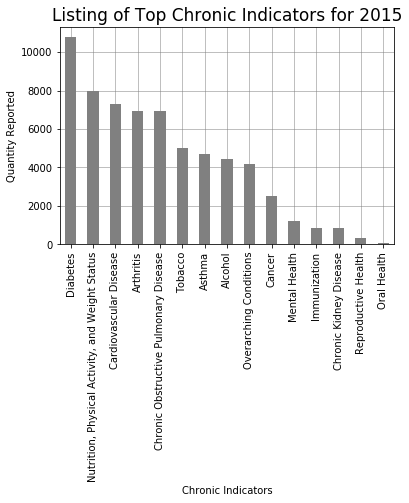

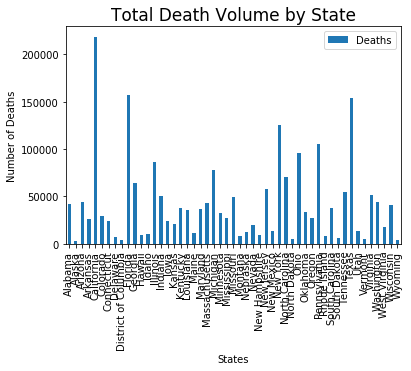

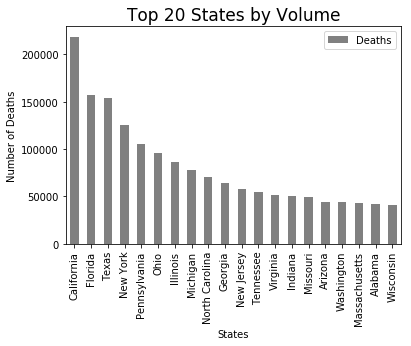

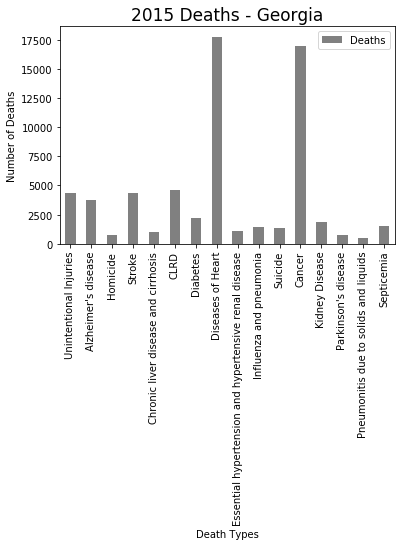

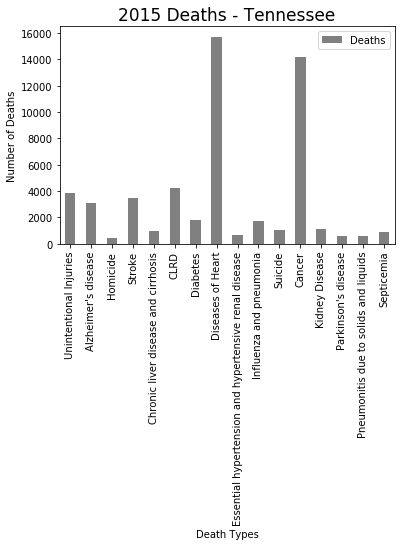

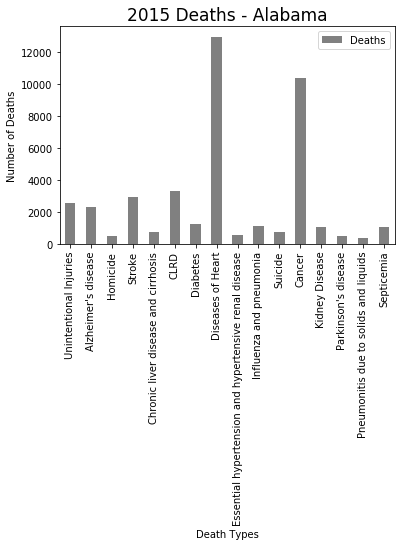

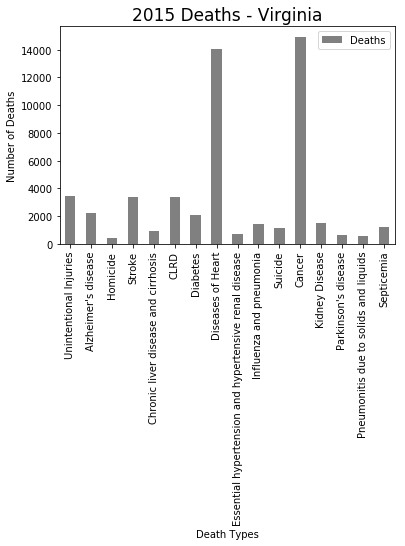

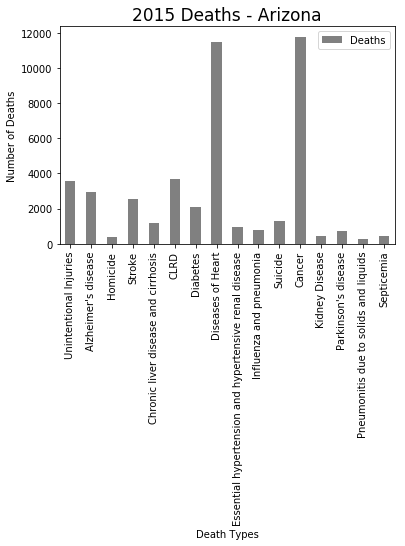

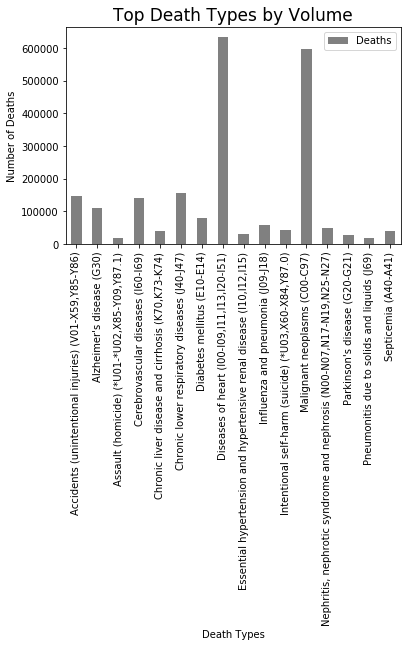

,Year,113 Cause Name,Cause Name,State,Deaths,Age-adjusted Death Rate
7933,2015,"Diseases of heart (I00-I09,I11,I13,I20-I51)",Diseases of Heart,New Hampshire,2571.0,149.0
7943,2015,"Diseases of heart (I00-I09,I11,I13,I20-I51)",Diseases of Heart,Rhode Island,2371.0,160.4
7930,2015,"Diseases of heart (I00-I09,I11,I13,I20-I51)",Diseases of Heart,Montana,2104.0,155.8
7911,2015,"Diseases of heart (I00-I09,I11,I13,I20-I51)",Diseases of Heart,Delaware,1940.0,165.2
7945,2015,"Diseases of heart (I00-I09,I11,I13,I20-I51)",Diseases of Heart,South Dakota,1711.0,150.9
7938,2015,"Diseases of heart (I00-I09,I11,I13,I20-I51)",Diseases of Heart,North Dakota,1323.0,142.4
7950,2015,"Diseases of heart (I00-I09,I11,I13,I20-I51)",Diseases of Heart,Vermont,1311.0,152.5
7912,2015,"Diseases of heart (I00-I09,I11,I13,I20-I51)",Diseases of Heart,District of Columbia,1217.0,187.6
7955,2015,"Diseases of heart (I00-I09,I11,I13,I20-I51)",Diseases of Heart,Wyoming,1030.0,159.4
7905,2015,"Diseases of heart (I00-I09,I11,I13,I20-I51)",Diseases of Heart,Alaska,846.0,154.1


In [2]:


# Reading files
death_data = '../fastfoodfacts/resources/NCHS_LeadingCauses.csv'
chronic_ind_data = '../fastfoodfacts/resources/U.S._Chronic_Disease_Indicators_N.csv'
death_data_df = pd.read_csv(death_data, encoding = 'ISO-8859-1')
chronic_ind_data_df = pd.read_csv(chronic_ind_data, encoding = 'ISO-8859-1')

# Starting analysis on the chronic indicators file
# Note the number of records
chronic_ind_data_df.info()

# Notice the drop in the number of records
chronic_ind_data_df[chronic_ind_data_df['YearEnd'] == 2015].info()

# Need the 2015 only data
chronic_ind_data_df = chronic_ind_data_df[chronic_ind_data_df['YearEnd'] == 2015]
# chronic_ind_data_df['Topic'].value_counts()
counts_ind = chronic_ind_data_df['Topic'].value_counts()

# Plotting chronic indicators for 2015
counts_ind.plot(kind='bar', color=['gray'])
plt.ylabel("Quantity Reported", size=10)
plt.grid(True, color='gray', linestyle='-', linewidth=.5)
plt.xlabel("Chronic Indicators", size=10)
plt.title('Listing of Top Chronic Indicators for 2015', size=17)
plt.savefig('../fastfoodfacts/resources/TopdiseaseInd.png', bbox_inches='tight', pad_inches=2)
plt.show()

# Analysis on Three Indicators (Diabeties, Heart, Nutrition)
# Chronic data based on Diabeties
chronic_dia_ind_df = chronic_ind_data_df[chronic_ind_data_df['Topic'].str.contains('Dia')]
chronic_dia_ind_df['Question'].value_counts()

chronic_gb_dia_ind_df = chronic_dia_ind_df.groupby(by=['YearEnd', 'LocationDesc', 'Question']).sum()
# chronic_gb_dia_ind_df

# Chronic data for the Cardio disease type
chronic_heart_ind_df = chronic_ind_data_df[chronic_ind_data_df['Topic'].str.contains('Cardio')]
chronic_heart_ind_df['Question'].value_counts()

# Analyzing nutrition data
chronic_nutri_ind_df = chronic_ind_data_df[chronic_ind_data_df['Topic'].str.contains('Nutr')]
chronic_nutri_ind_df['Question'].value_counts()

# Looked at pulmonary data and it doesn't seem to fit the fast food deal
# Recommendation will be to focus on diabeties, heart, nutrition
chronic_pulm_ind_df = chronic_ind_data_df[chronic_ind_data_df['Topic'].str.contains('Pulmonar')]
chronic_pulm_ind_df['Question'].value_counts()

# Death data by state
death_data_year = death_data_df[death_data_df['Year'] == 2015]
# death_data_year.head()

# Analyzing the deaths by type and state
death_data_year['113 Cause Name'].value_counts()
death_data_year['113 Cause Name'].unique()

# Getting the min death type and state
death_data_year.min()

# Getting the max death type and state
death_data_year.max()

# Looking at the number of deaths and seeing which state has the most and what type
death_data_year.sort_values(by='Deaths', ascending=False).head()

# Since 'all causes' acts as a summary I want to strip that out of the figures
death_data_not_all_causes = death_data_year[death_data_year['113 Cause Name'] != 'All Causes']

# death_data_not_all_causes.head()

# In this dataset notice that the United States shows up as a state so let's strip that out as well
death_data_not_all_causes.sort_values(by='Deaths', ascending=False).head(10)

# This dataset is all death types and all states only
# This dataset is all death types and all states only
death_data_NAC_noUS = death_data_not_all_causes[death_data_not_all_causes['State'] != 'United States']
# death_data_NAC_noUS.head()

# Creating a groupby by year and state
death_gb_state_data = death_data_NAC_noUS.groupby(by=['Year', 'State']).sum().reset_index()

# Plotting deaths by state
death_gb_state_data.plot(kind='bar', x='State', y='Deaths', subplots=False)
plt.ylabel("Number of Deaths", size=10)
plt.xlabel("States", size=10)
plt.title('Total Death Volume by State', size=17)
plt.savefig('../fastfoodfacts/resources/StatesDeath.png', bbox_inches='tight', pad_inches=2)
plt.show()

# Preparing data to plot
death_gb_state_data = death_data_NAC_noUS.groupby(by=['Year', 'State']).sum().reset_index()
death_gb_state_data.sort_values('Deaths', ascending=False).head(20)
death_top20_states = death_gb_state_data.sort_values('Deaths', ascending=False).head(20)

# Plotting top 20 states
death_top20_states.plot.bar('State', 'Deaths', color='gray')
plt.ylabel("Number of Deaths", size=10)
plt.xlabel("States", size=10)
plt.title('Top 20 States by Volume', size=17)
plt.savefig('../fastfoodfacts/resources/Top20StatesDeath.png', bbox_inches='tight', pad_inches=2)
plt.show()

# Lets study  3 southern states - Alabama, Tennessee, Georgia
death_data_NAC_noUS[death_data_NAC_noUS['State'] == 'Georgia'].plot.bar('Cause Name', 'Deaths', color='gray')
plt.ylabel("Number of Deaths", size=10)
plt.xlabel("Death Types", size=10)
plt.title('2015 Deaths - Georgia', size=17)
plt.savefig('../fastfoodfacts/resources/GADeath.png', bbox_inches='tight', pad_inches=2)
plt.show()

death_data_NAC_noUS[death_data_NAC_noUS['State'] == 'Tennessee'].plot.bar('Cause Name', 'Deaths', color='gray')
plt.ylabel("Number of Deaths", size=10)
plt.xlabel("Death Types", size=10)
plt.title('2015 Deaths - Tennessee', size=17)
plt.savefig('../fastfoodfacts/resources/TNDeath.png', bbox_inches='tight', pad_inches=2)
plt.show()

death_data_NAC_noUS[death_data_NAC_noUS['State'] == 'Alabama'].plot.bar('Cause Name', 'Deaths', color='gray')
plt.ylabel("Number of Deaths", size=10)
plt.xlabel("Death Types", size=10)
plt.savefig('../fastfoodfacts/resources/ALDeath.png', bbox_inches='tight', pad_inches=2)
plt.title('2015 Deaths - Alabama', size=17)
plt.show()


# Analysis suggest that some states don't have the same level of death cardio or cancer death rates
# Notice that Virginia has less heart disease than the southern states
death_data_NAC_noUS[death_data_NAC_noUS['State'] == 'Virginia'].plot.bar('Cause Name', 'Deaths', color='gray')
plt.ylabel("Number of Deaths", size=10)
plt.xlabel("Death Types", size=10)
plt.title('2015 Deaths - Virginia', size=17)
plt.savefig('../fastfoodfacts/resources/VADeath.png')
plt.show()

# Notice that Arizona has less heart disease than the southern states
death_data_NAC_noUS[death_data_NAC_noUS['State'] == 'Arizona'].plot.bar('Cause Name', 'Deaths', color='gray')
plt.ylabel("Number of Deaths", size=10)
plt.xlabel("Death Types", size=10)
plt.title('2015 Deaths - Arizona', size=17)
plt.show()



# I want to compare size of population to number of deaths/death types
# This is where I will insert that code

death_gb_cause_data = death_data_NAC_noUS.groupby(by=['Year', '113 Cause Name']).sum().reset_index()


death_gb_cause_data.plot(kind='bar', x='113 Cause Name', y='Deaths', color='gray')
plt.ylabel("Number of Deaths", size=10)
plt.xlabel("Death Types", size=10)
plt.title('Top Death Types by Volume', size=17)
plt.savefig('../fastfoodfacts/resources/topDeathtypes.png', bbox_inches='tight', pad_inches=2)
plt.show()


# Plotting diabeties data
death_dia_data = death_data_NAC_noUS[death_data_NAC_noUS['Cause Name'].str.contains('Dia')]
death_dia_data.sort_values('Deaths', ascending=False)
death_dia_data.sort_values('Deaths', ascending=False).tail(10)

# Plotting cardio data
death_heart_data = death_data_NAC_noUS[death_data_NAC_noUS['Cause Name'].str.contains('Heart')]
death_heart_data.sort_values('Deaths', ascending=False)
death_heart_data.sort_values('Deaths', ascending=False).tail(10)

# death_dia_data.plot(kind='bar', x='State', y='Deaths')
# plt.show()


# death_heart_data.plot(kind='bar', x='State', y='Deaths')
# plt.show()




In [19]:
eduByState.head()

,Less than 9th grade,"9th to 12th grade, no diploma",High school graduate,"Some college, no degree",Associate's degree,Bachelor's degree,Graduate or professional degree
State,,,,,,,
Alabama,111784,266587,801204,694519,219221,447864,264964
Alaska,6267,18345,101141,111073,32571,70282,36635
Arizona,268015,426722,1289846,1409771,412632,869186,496777
Arkansas,51095,97309,387489,326751,81629,208442,115674
California,2591171,2414803,6425995,7160282,2181414,5739416,3242559


In [57]:
count_edu_AL = eduByState.loc['Alabama', :].describe()
count_edu_TN = eduByState.loc['Tennessee', :].describe()
count_edu_GA = eduByState.loc['Georgia', :].describe()
count_edu_VA = eduByState.loc['Virginia', :].describe()

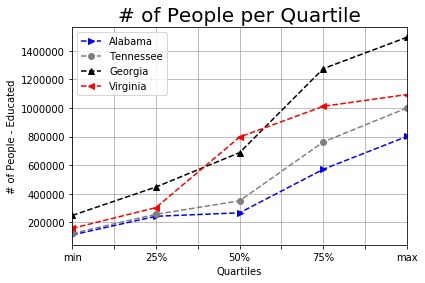

In [84]:
fig, ax = plt.subplots()
count_edu_AL[3:8].plot(ax=ax, color='blue', linestyle='--', label='Alabama', marker='>')
count_edu_TN[3:8].plot(ax=ax, color='gray', linestyle='--', label='Tennessee', marker='o')
count_edu_GA[3:8].plot(ax=ax, color='black', linestyle='--', label='Georgia', marker='^')
count_edu_VA[3:8].plot(ax=ax, color='red', linestyle='--', label='Virginia', marker='<')
plt.grid(True, color='gray', linestyle='-', linewidth=.5)
plt.ylabel("# of People - Educated", size=10)
plt.xlabel("Quartiles", size=10)
plt.legend(loc='best')
plt.title('# of People per Quartile', size=20)
plt.show()

In [64]:
death_data_NAC_noUS[death_data_NAC_noUS['State'] == 'Georgia']['Deaths'].sum()

64115.0

In [20]:
death_data_NAC_noUS[death_data_NAC_noUS['State'] == 'Tennessee']['Deaths'].sum()

54454.0

In [21]:
death_data_NAC_noUS[death_data_NAC_noUS['State'] == 'Alabama']['Deaths'].sum()

42073.0

In [30]:
death_data_NAC_noUS[death_data_NAC_noUS['State'] == 'Virginia']['Deaths'].sum()

51928.0

In [33]:
ttest_GA = eduByState.loc['Georgia', :]
ttest_VA = eduByState.loc['Virginia', :]

In [34]:
stats.ttest_ind(ttest_GA,ttest_VA)

Ttest_indResult(statistic=0.7049455419057673, pvalue=0.49430005843719615)

In [36]:
ttest_AL = eduByState.loc['Alabama', :]
ttest_VA = eduByState.loc['Virginia', :]

In [37]:
stats.ttest_ind(ttest_GA,ttest_VA)

Ttest_indResult(statistic=-1.4828186867703534, pvalue=0.16390322688281336)

In [4]:
popDFmapped.head()

,Population,State Code (FIPS),County Code (FIPS),State,County,Abbreviation
0,208563,1,3,Alabama,Baldwin County,AL
1,114611,1,15,Alabama,Calhoun County,AL
2,82471,1,43,Alabama,Cullman County,AL
3,70900,1,49,Alabama,DeKalb County,AL
4,81799,1,51,Alabama,Elmore County,AL


In [11]:
popDFstate = popDFmapped.groupby(by='State').sum().sort_values(by='Population', ascending=False)

In [15]:
popDFstate_only = popDFstate['Population']

In [20]:
popDFstate_only = pd.DataFrame(popDFstate_only, columns=['Population'])

In [28]:
popDFstate_only = popDFstate_only.reset_index()

In [29]:
death_gb_state_data.head()

,Year,State,Deaths,Age-adjusted Death Rate
0,2015,Alabama,42073.0,745.8
1,2015,Alaska,3413.0,583.6
2,2015,Arizona,44402.0,547.5
3,2015,Arkansas,26361.0,748.1
4,2015,California,218595.0,523.6


In [30]:
popDeathstateDataDF = pd.merge(popDFstate_only, death_gb_state_data, on='State', how='outer')

In [75]:
popDeathstateDataDF = popDeathstateDataDF[['Year', 'State', 'Population', 'Deaths']]

In [76]:
popDeathstateDataDF.head()

,Year,State,Population,Deaths
0,2015,California,38745526.0,218595.0
1,2015,Texas,24321465.0,153427.0
2,2015,Florida,19970450.0,156803.0
3,2015,New York,18741516.0,124904.0
4,2015,Pennsylvania,11818329.0,105314.0


In [77]:
for x in popDeathstateDataDF.iterrows():
    ratio = (x[1]['Deaths'] / x[1]['Population']) * 100
    popDeathstateDataDF.set_value(value=ratio, col='ratio', index=x[0])

In [82]:
popDeathstateDataDF.sort_values(by='ratio', ascending=False).head()

,Year,State,Population,Deaths,ratio
49,2015,Vermont,161531.0,4702.0,2.910896
43,2015,West Virginia,731019.0,18072.0,2.472166
47,2015,South Dakota,296690.0,6409.0,2.160167
48,2015,Wyoming,179175.0,3841.0,2.143714
36,2015,Mississippi,1323725.0,26716.0,2.018244


In [84]:
avgpopDeathstateDF = popDeathstateDataDF['ratio'].describe()

In [91]:
above_avg_death_rate = popDeathstateDataDF[popDeathstateDataDF['ratio'] >= avgpopDeathstateDF['mean']]

In [259]:
above_avg_death_rate.head()

,Year,State,Population,Deaths,ratio
18,2015,Tennessee,4560050.0,54454.0,1.194154
21,2015,Missouri,4139912.0,49273.0,1.190194
23,2015,Alabama,3630681.0,42073.0,1.158818
26,2015,Louisiana,3396087.0,36027.0,1.060839
29,2015,Oklahoma,2426888.0,33287.0,1.371592


In [165]:
len(above_avg_death_rate['State'])

18

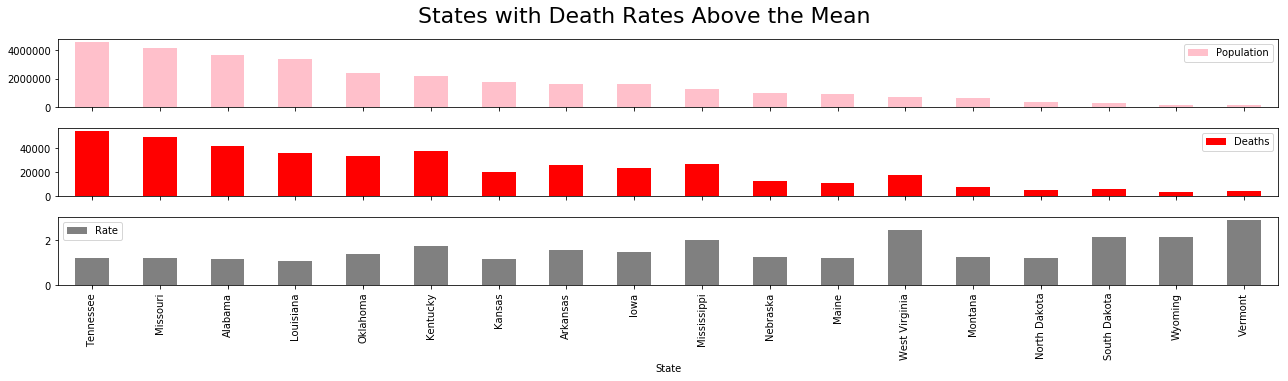

In [198]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='all', figsize=(18,5))
plt.suptitle('States with Death Rates Above the Mean', x=0.5, y=1.05, fontsize=22)
above_avg_death_rate.plot.bar(x='State', y='Population', ax=ax1, color='pink', label='Population')
above_avg_death_rate.plot.bar(x='State', y='Deaths', ax=ax2, color='red', label='Deaths')
above_avg_death_rate.plot.bar(x='State', y='ratio', ax=ax3, color='gray', label='Rate')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('../fastfoodfacts/resources/statesabovemean.png', bbox_inches='tight', pad_inches=2)
plt.xticks(np.arange(18), above_avg_death_rate.loc[:, 'State'], rotation=90 )
plt.show()

In [199]:
res_data = pd.ExcelFile('../fastfoodfacts/resources/DataDownload.xls')
restaurant_df = pd.read_excel(res_data, 'RESTAURANTS')

restaurant_df = restaurant_df.rename(columns={'FFR09':'Fast Food Restaurants 2009',
                                              'FFR14':'Fast Food Restaurants 2014',
                                              'PCH_FFR_09_14':'Fast-food restaurants (% change)',
                                              'FFRPTH09':'Fast-food restaurants/1,000 pop 2009',
                                              'FFRPTH14':'Fast-food restaurants/1,000 pop 2014',
                                              'PCH_FFRPTH_09_14':'Fast-food restaurants/1,000 pop (% change)'})
restaurant_df.head()

fast_food_df=restaurant_df[['FIPS',
                            'State',
                            'County',
                            'Fast Food Restaurants 2009',
                            'Fast Food Restaurants 2014',
                            'Fast-food restaurants (% change)',
                            'Fast-food restaurants/1,000 pop 2009',
                            'Fast-food restaurants/1,000 pop 2014',
                            'Fast-food restaurants/1,000 pop (% change)']].copy()
fast_food_df.head()

# fast_food_df.insert(loc=0,column='Yearly Growth Rate %',value=int)
# fast_food_df.head()
# fast_food_df.insert(loc=0,column='Fast Food Restaurants 2015 (PROJECTED)',value=int)

ff_df=fast_food_df[['FIPS',
                    'State',
                    'County',
                    'Fast Food Restaurants 2009',
                    'Fast Food Restaurants 2014',
                    'Fast-food restaurants (% change)',
                    'Fast-food restaurants/1,000 pop 2009',
                    'Fast-food restaurants/1,000 pop 2014',
                    'Fast-food restaurants/1,000 pop (% change)']].copy()

for index,row in ff_df.iterrows():
    total_gr = row['Fast-food restaurants (% change)']
    yr_gr = total_gr/5
    ff_df.set_value(index,'Yearly Growth Rate %',yr_gr)
    ff09 = row['Fast Food Restaurants 2009']
    ff14 = row['Fast Food Restaurants 2014']
    projection = round((ff14*(yr_gr/100)) + ff14,0)
    ff_df.set_value(index,'Fast Food Restaurants 2015 (PROJECTED)',projection)
   
    
    
    
        

# del ff_df['Fast-food restaurants/1,000 pop 2009']
# del ff_df['Fast-food restaurants/1,000 pop 2014']
# del ff_df['Fast-food restaurants/1,000 pop (% change)']

resbystate15 = ff_df.groupby(["State"])['Fast Food Restaurants 2015 (PROJECTED)'].sum()
resbystate14 =  ff_df.groupby(["State"])['Fast Food Restaurants 2014'].sum()
resbystate15.head(20)
resbystate=pd.DataFrame({'Abbreviation':resbystate15.index,'Fast Food Restaurant Count 2014':resbystate14.values, 'Fast Food Restaurant Count 2015 (prj)':resbystate15.values}).copy()
resbystate.head()

sns.palplot(sns.hls_palette(16, l=.3, s=.8))
plt.figure(figsize=(20,5))
x_axis = np.arange(len(resbystate))
tick_locations = [value for value in x_axis]
ff1=plt.bar(x_axis, resbystate['Restaurant Count 2015 (prj)'], width = 0.2,align='center')
ff2=plt.bar(x_axis + 0.25, resbystate['Restaurant Count 2014'], width = 0.2,align='center')

plt.xticks(tick_locations, resbystate['State'], rotation="vertical")
plt.title('Projected Restaurant Volume for 2015')
plt.xlabel('States')
plt.ylabel('Restaurant Volume')
plt.legend()
plt.tight_layout()
plt.show()

countypop = pd.merge(ff_df,popDFmapped,how='inner',on=['Abbreviation','County'])
countypop.head()


for index,row in countypop.iterrows():
    pop = row['Population']
    ffres14 = row['Fast Food Restaurants 2014']
    ffres15 = row['Fast Food Restaurants 2015 (PROJECTED)']
    ffpercap14 = ((ffres14/pop)*100)
    ffpercap15 = ((ffres15/pop)*100)
    ff_df.set_value(index,'Fast Food Restaurants Per Capita, 2014',ffpercap14)
    ff_df.set_value(index,'Fast Food Restaurants Per Capita, 2015',ffpercap15)
    
countypop.head()

#Normalized bar chart  
sns.palplot(sns.hls_palette(16, l=.3, s=.8))
plt.figure(figsize=(20,5))
x_axis = np.arange(len(countypop))
tick_locations = [value for value in x_axis]
ff1=plt.bar(x_axis, countypop['Fast Food Restaurants Per Capita, 2014'], width = 0.2,align='center')
ff2=plt.bar(x_axis + 0.25, countypop['Fast Food Restaurants Per Capita, 2015'], width = 0.2,align='center')

# plt.xticks(tick_locations, countypop['Abbreviation'], rotation="vertical")
plt.title('Fast Food Restaurant Volume per Capita, 2014-2015')
plt.xlabel('States')
plt.ylabel('Restaurant Volume')
plt.legend()
plt.tight_layout()
plt.show()

KeyError: 'Restaurant Count 2015 (prj)'

In [256]:
abbrMap.head()

,State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [232]:
ff_df_gb_state = ff_df.groupby(by='State').sum()

In [233]:
ff_df_gb_state.head()

,FIPS,Fast Food Restaurants 2009,Fast Food Restaurants 2014,Fast-food restaurants (% change),"Fast-food restaurants/1,000 pop 2009","Fast-food restaurants/1,000 pop 2014","Fast-food restaurants/1,000 pop (% change)",Yearly Growth Rate %,Fast Food Restaurants 2015 (PROJECTED)
State,,,,,,,,,
AK,62452,396,429,17.619653,10.630459,9.190640,-68.193607,3.523931,425.0
AL,71489,3322,3561,96.222891,38.254782,39.071534,107.758944,19.244578,3626.0
AR,380625,1881,1939,429.949014,39.410640,39.547708,540.134727,85.989803,1963.0
AZ,60208,4071,4211,-3.124578,8.143672,7.963666,-41.842943,-0.624916,4241.0
CA,351364,25842,28292,166.514866,37.328614,37.524070,47.199960,33.302973,28842.0


In [234]:
ff_df_gb_state = ff_df_gb_state.reset_index()

In [235]:
ff_df_gb_state.head()

,State,FIPS,Fast Food Restaurants 2009,Fast Food Restaurants 2014,Fast-food restaurants (% change),"Fast-food restaurants/1,000 pop 2009","Fast-food restaurants/1,000 pop 2014","Fast-food restaurants/1,000 pop (% change)",Yearly Growth Rate %,Fast Food Restaurants 2015 (PROJECTED)
0,AK,62452,396,429,17.619653,10.630459,9.190640,-68.193607,3.523931,425.0
1,AL,71489,3322,3561,96.222891,38.254782,39.071534,107.758944,19.244578,3626.0
2,AR,380625,1881,1939,429.949014,39.410640,39.547708,540.134727,85.989803,1963.0
3,AZ,60208,4071,4211,-3.124578,8.143672,7.963666,-41.842943,-0.624916,4241.0
4,CA,351364,25842,28292,166.514866,37.328614,37.524070,47.199960,33.302973,28842.0


In [238]:
ff_df_gb_state = pd.merge(ff_df_gb_state, abbrMap, left_on='State', right_on='Abbreviation', how='outer')

In [239]:
ff_df_gb_state.head()

,State_x,FIPS,Fast Food Restaurants 2009,Fast Food Restaurants 2014,Fast-food restaurants (% change),"Fast-food restaurants/1,000 pop 2009","Fast-food restaurants/1,000 pop 2014","Fast-food restaurants/1,000 pop (% change)",Yearly Growth Rate %,Fast Food Restaurants 2015 (PROJECTED),State_y,Abbreviation
0,AK,62452,396,429,17.619653,10.630459,9.190640,-68.193607,3.523931,425.0,Alaska,AK
1,AL,71489,3322,3561,96.222891,38.254782,39.071534,107.758944,19.244578,3626.0,Alabama,AL
2,AR,380625,1881,1939,429.949014,39.410640,39.547708,540.134727,85.989803,1963.0,Arkansas,AR
3,AZ,60208,4071,4211,-3.124578,8.143672,7.963666,-41.842943,-0.624916,4241.0,Arizona,AZ
4,CA,351364,25842,28292,166.514866,37.328614,37.524070,47.199960,33.302973,28842.0,California,CA


In [240]:
ff_df_gb_state = ff_df_gb_state[['State_y', 'Fast Food Restaurants 2015 (PROJECTED)']]

In [242]:
ff_df_gb_state.head()

,State_y,Fast Food Restaurants 2015 (PROJECTED)
0,Alaska,425.0
1,Alabama,3626.0
2,Arkansas,1963.0
3,Arizona,4241.0
4,California,28842.0


In [243]:
incomeByState = incomeByState.reset_index()

In [244]:
incomeByState_ff_df = pd.merge(incomeByState, ff_df_gb_state, left_on='State', right_on='State_y', how='outer')

In [249]:
incomeByState_ff_df.head()

,State,< $10k,"$10K - $14,999","$15K - $19,999","$20K - $24,999","$25K - $29,999","$30K - $34,999","$35K - $39,999","$40K - $44,999","$45K - $49,999","$50K - $59,999","$60K - $74,999","$75K - $99,999","$100K - $124,999","$125K - $149,999","$150K - $199,999",$200K +,State_y,Fast Food Restaurants 2015 (PROJECTED)
0,Alabama,117740.0,82051.0,81954.0,77103.0,75533.0,73493.0,69537.0,64044.0,57363.0,109256.0,130940.0,163814.0,106967.0,57537.0,60731.0,54724.0,Alabama,3626.0
1,Alaska,5148.0,4504.0,4093.0,5404.0,5336.0,5885.0,4815.0,5904.0,6524.0,13298.0,16693.0,24791.0,21870.0,13700.0,17154.0,14205.0,Alaska,425.0
2,Arizona,178550.0,118827.0,113126.0,125785.0,125696.0,120881.0,120530.0,125073.0,103507.0,214202.0,247124.0,309522.0,195761.0,116701.0,123372.0,119731.0,Arizona,4241.0
3,Arkansas,53205.0,34318.0,33389.0,37538.0,34367.0,36272.0,30819.0,34560.0,31788.0,55521.0,64676.0,71239.0,47523.0,27354.0,25144.0,25572.0,Arkansas,1963.0
4,California,688487.0,572418.0,512769.0,568814.0,485542.0,529878.0,489353.0,507198.0,450680.0,874479.0,1199686.0,1551800.0,1213874.0,797890.0,1010483.0,1301650.0,California,28842.0


In [262]:
for index,row in incomeByState_ff_df.iterrows():
    incBelow40 = row[1:8].sum()
    incAbove40 = row[8:17].sum()
    incomeByState_ff_df.set_value(value=incBelow40, col='IncBelow40', index=index)
    incomeByState_ff_df.set_value(value=incAbove40, col='IncAbove40', index=index)

In [264]:
incomeByState_ff_df = incomeByState_ff_df[['State', 'Fast Food Restaurants 2015 (PROJECTED)','IncBelow40', 'IncAbove40']]

In [265]:
incomeByState_ff_df.head()

,State,Fast Food Restaurants 2015 (PROJECTED),IncBelow40,IncAbove40
0,Alabama,3626.0,577411.0,805376.0
1,Alaska,425.0,35185.0,134139.0
2,Arizona,4241.0,903395.0,1554993.0
3,Arkansas,1963.0,259908.0,383377.0
4,California,28842.0,3847261.0,8907740.0


In [319]:
x1 = incomeByState_ff_df['Fast Food Restaurants 2015 (PROJECTED)']
y1 = incomeByState_ff_df['IncBelow40']
#x1 = x1.dropna()
#y1 = y1.dropna()
#slope, intercept, r_value, p_value, std_err = stats.linregress(x1, y1)

In [320]:
x1 = x1.fillna(0)

In [321]:
y1 = y1.fillna(0)

In [322]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x1, y1)

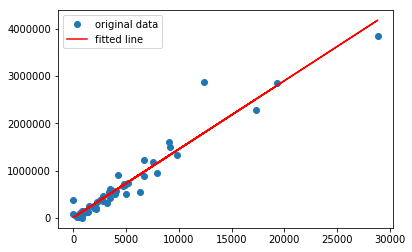

In [324]:
plt.plot(x1, y1, 'o', label='original data')
plt.plot(x1, intercept + slope*x1, 'r', label='fitted line')
plt.legend()
plt.show()

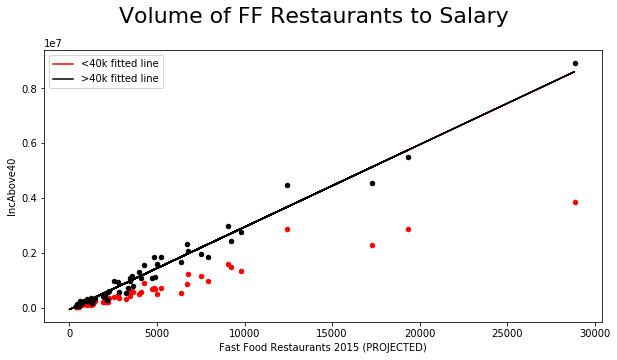

In [339]:
x1 = incomeByState_ff_df['Fast Food Restaurants 2015 (PROJECTED)']
y1 = incomeByState_ff_df['IncBelow40']
x1 = x1.fillna(0)
y1 = y1.fillna(0)
slope, intercept, r_value, p_value, std_err = stats.linregress(x1, y1)
x2 = incomeByState_ff_df['Fast Food Restaurants 2015 (PROJECTED)']
y2 = incomeByState_ff_df['IncAbove40']
x2 = x2.fillna(0)
y2 = y2.fillna(0)
slope, intercept, r_value, p_value, std_err = stats.linregress(x2, y2)
fig, ax = plt.subplots(figsize=(10,5), sharey='all')
plt.suptitle('Volume of FF Restaurants to Salary', x=0.5, y=1, fontsize=22)
incomeByState_ff_df.plot.scatter(x='Fast Food Restaurants 2015 (PROJECTED)', ax=ax, y='IncBelow40', color='red', marker='o')
incomeByState_ff_df.plot.scatter(x='Fast Food Restaurants 2015 (PROJECTED)', ax=ax, y='IncAbove40', color='black', marker='o')
plt.plot(x1, intercept + slope*x1, 'r', label='<40k fitted line')
plt.plot(x2, intercept + slope*x2, 'black', label='>40k fitted line')
plt.legend(loc='best')
plt.savefig('../fastfoodfacts/resources/ffincrelation.png', bbox_inches='tight', pad_inches=2)
plt.show()

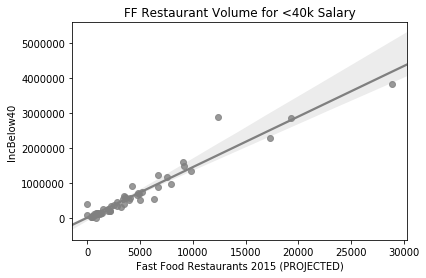

In [342]:
# rg=sns.regplot
x1 = incomeByState_ff_df['Fast Food Restaurants 2015 (PROJECTED)']
y1 = incomeByState_ff_df['IncBelow40']
x1 = x1.fillna(0)
y1 = y1.fillna(0)
slope, intercept, r_value, p_value, std_err = stats.linregress(x1, y1)
y = y1
x = x1
d = incomeByState_ff_df
# Show the results of a linear regression within each dataset
ax = sns.regplot(x=x, y=y, data=d, color='gray')
plt.title('FF Restaurant Volume for <40k Salary')
plt.show()

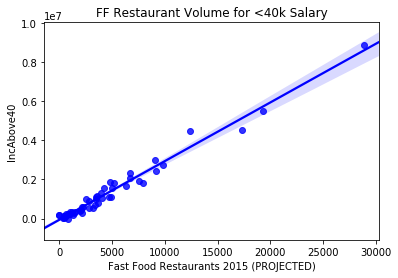

In [343]:
# rg=sns.regplot
x2 = incomeByState_ff_df['Fast Food Restaurants 2015 (PROJECTED)']
y2 = incomeByState_ff_df['IncAbove40']
x2 = x2.fillna(0)
y2 = y2.fillna(0)
slope, intercept, r_value, p_value, std_err = stats.linregress(x2, y2)
y = y2
x = x2
d = incomeByState_ff_df
# Show the results of a linear regression within each dataset
ax = sns.regplot(x=x, y=y, data=d, color='blue')
plt.title('FF Restaurant Volume for <40k Salary')
plt.show()

x1 slope= 300.411993641 x1 r^2= 0.975617658287
x2 slope= 144.728589825 x2 r^2= 0.934746568289


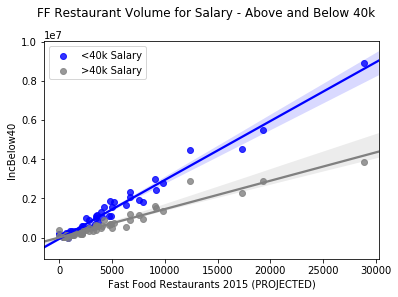

In [376]:
# rg=sns.regplot
x2 = incomeByState_ff_df['Fast Food Restaurants 2015 (PROJECTED)']
y2 = incomeByState_ff_df['IncAbove40']
x2 = x2.fillna(0)
y2 = y2.fillna(0)
slope, intercept, r_value, p_value, std_err = stats.linregress(x2, y2)
y = y2
x = x2
d = incomeByState_ff_df
r2 = r_value*r_value
print('x1 slope=', slope, 'x1 r^2=', r2)
# Show the results of a linear regression within each dataset
ax = sns.regplot(x=x, y=y, data=d, color='blue', label='<40k Salary')
x1 = incomeByState_ff_df['Fast Food Restaurants 2015 (PROJECTED)']
y1 = incomeByState_ff_df['IncBelow40']
x1 = x1.fillna(0)
y1 = y1.fillna(0)
slope, intercept, r_value, p_value, std_err = stats.linregress(x1, y1)
y = y1
x = x1
d = incomeByState_ff_df
r3 = r_value*r_value
print('x2 slope=', slope, 'x2 r^2=', r3)
# Show the results of a linear regression within each dataset
ax = sns.regplot(x=x, y=y, data=d, color='gray', label='>40k Salary')
plt.suptitle('FF Restaurant Volume for Salary - Above and Below 40k', x=0.5, y=1, fontsize=12)
plt.legend(loc='best')
plt.savefig('../fastfoodfacts/resources/ffsalaryincrelation.png', bbox_inches='tight', pad_inches=2)
plt.show()